In [2]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import catboost
import xgboost as xgb
import lightgbm
from bayes_opt import BayesianOptimization

from sklearn.model_selection import RepeatedKFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e23/train.csv", index_col="id")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e23/test.csv", index_col="id")
orig_train = pd.read_csv(r'/kaggle/input/software-defect-prediction/jm1.csv')
for object_features in list(orig_train.loc[:, orig_train.dtypes == 'O']):
    orig_train[object_features] = orig_train[object_features].replace({'?' : np.nan}).astype('float64')

In [5]:
df_X = df_train.drop("defects", axis=1)
df_y = df_train["defects"]

In [ ]:
def cat_eval(iterations, depth, learning_rate, l2_leaf_reg, min_data_in_leaf):
    params = {
        'iterations': int(iterations),
        'depth': int(depth),
        'learning_rate': learning_rate,
        'l2_leaf_reg': l2_leaf_reg,
        'min_data_in_leaf': int(min_data_in_leaf),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'class_weights': class_weights,
        'verbose': False
    }
    cv_dataset = catboost.Pool(data=df_X, label=df_y)
    scores = catboost.cv(cv_dataset, params, fold_count=4, verbose=False)
    return scores['test-AUC-mean'].max()

pbounds = {
    'iterations': (100, 2000),
    'depth': (4, 10),
    'learning_rate': (0.001, 0.1),
    'l2_leaf_reg': (1, 10),
    'min_data_in_leaf': (1, 40)
}

cat_opt = BayesianOptimization(
    f=cat_eval,
    pbounds=pbounds
)

cat_opt.maximize(n_iter=6, init_points=4)

In [51]:
best_params = cat_opt.max
print(f"Best ROC-AUC: {best_params['target']}")
print(f"Best hyperparameters: {best_params['params']}")

Best ROC-AUC: 0.7918948187057542
Best hyperparameters: {'depth': 5.051883470252908, 'iterations': 1379.5559065948016, 'l2_leaf_reg': 5.2368409506530025, 'learning_rate': 0.0921138189035918, 'min_data_in_leaf': 19.446127192389262}


In [58]:
cgb = catboost.CatBoostClassifier(
    depth=round(best_params['params']['depth']),
    iterations=round(best_params['params']['iterations']),
    l2_leaf_reg=best_params['params']['l2_leaf_reg'],
    learning_rate=best_params['params']['learning_rate'],
    min_data_in_leaf=best_params['params']['min_data_in_leaf'],
    class_weights=class_weights,
    random_state=0,
    verbose=False
)
cgb.fit(df_X, df_y)
preds = cgb.predict_proba(df_test)[:, -1] 

In [ ]:
counter = 0
auc_mean = 0
preds = np.zeros(len(df_test))
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)

for fold, (train_idx, valid_idx) in enumerate(rkf.split(df_X)):
    X_train, y_train = df_X.iloc[train_idx], df_y.iloc[train_idx]
    X_valid, y_valid = df_X.iloc[valid_idx], df_y.iloc[valid_idx]

    print(f'\n:::::::::::::::::: Fold ~ {fold+1} :::::::::::::::::::')
        
    cgb.fit(X_train, y_train)
    oof = cgb.predict_proba(X_valid)[:, -1]
    
    auc = roc_auc_score(y_valid, oof)
    if (auc <= 0.79): 
        print('\nAUC Score:', auc, ' # was ignored.')
    
    if (auc > 0.791): 
        counter += 1
        print('\nAUC Score:', auc, ' # it is ok.')
        auc_mean += roc_auc_score(y_valid, oof) 
        preds += cgb.predict_proba(df_test)[:, -1] 

auc_mean = auc_mean / counter
preds = preds / counter

print('\n', '='* 40)
print(' .'* 20)
print(' AUC Score (mean):', auc_mean)
print(' .'* 20)
print('='* 40, '\n')

print('Total number of folds:', rkf.get_n_splits(df_X, df_y))
print('Number of valid folds:', counter)

In [59]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s3e23/sample_submission.csv")
df_sub["defects"] = preds
df_sub.to_csv("ans_16.csv", index=False)

In [34]:
print(orig_train.shape)
orig_train.head()

(10885, 22)


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17.0,36.0,112.0,86.0,13.0,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17.0,135.0,329.0,271.0,5.0,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11.0,16.0,76.0,50.0,7.0,True


In [101]:
print(df_train.shape)
df_train.head()

(101763, 22)


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [53]:
print(df_test.shape)
df_test.head()

(67842, 21)


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,22636.74,...,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,14482.46,...,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,116160.08,...,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,16135.47,...,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
4,22.0,3.0,1.0,3.0,52.0,238.42,0.10,9.60,26.70,2624.49,...,145.80,16,0,4,0,12.0,15.0,30.0,24.0,5.0


#### EDA

In [31]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
loc,101763.0,37.347160,54.600401,1.0,13.00,22.00,42.00,3442.00
v(g),101763.0,5.492684,7.900855,1.0,2.00,3.00,6.00,404.00
ev(g),101763.0,2.845022,4.631262,1.0,1.00,1.00,3.00,165.00
iv(g),101763.0,3.498826,5.534541,1.0,1.00,2.00,4.00,402.00
n,101763.0,96.655995,171.147191,0.0,25.00,51.00,111.00,8441.00
v,101763.0,538.280956,1270.791601,0.0,97.67,232.79,560.25,80843.08
l,101763.0,0.111634,0.100096,0.0,0.05,0.09,0.15,1.00
d,101763.0,13.681881,14.121306,0.0,5.60,9.82,18.00,418.20
i,101763.0,27.573007,22.856742,0.0,15.56,23.36,34.34,569.78
e,101763.0,20853.589876,190571.405427,0.0,564.73,2256.23,10193.24,16846621.12


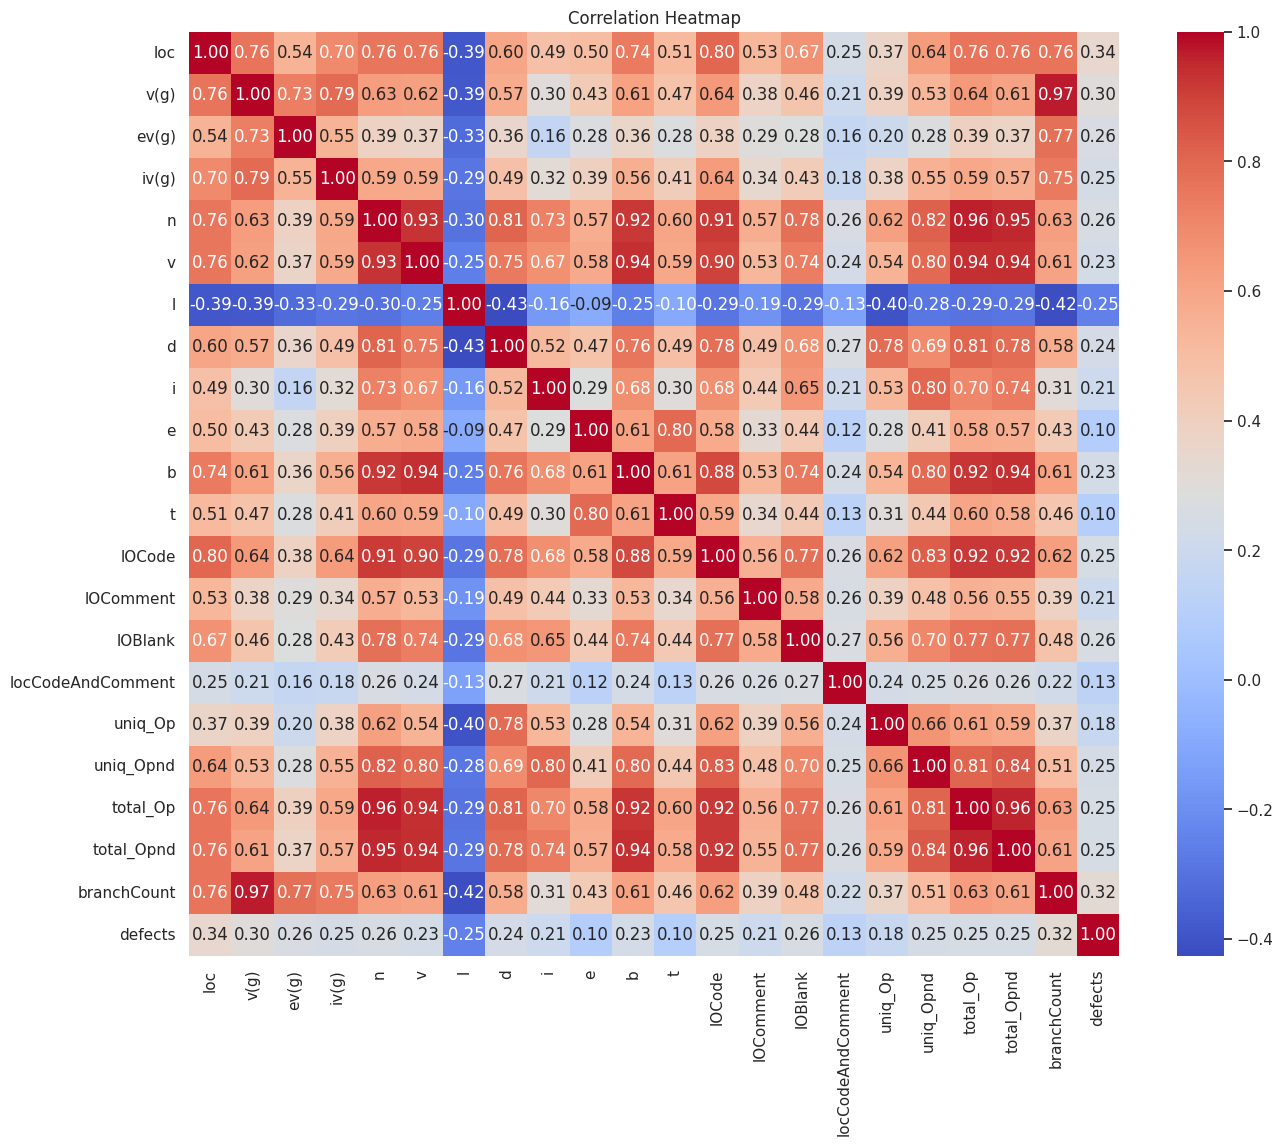

In [32]:
corr = df_train.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


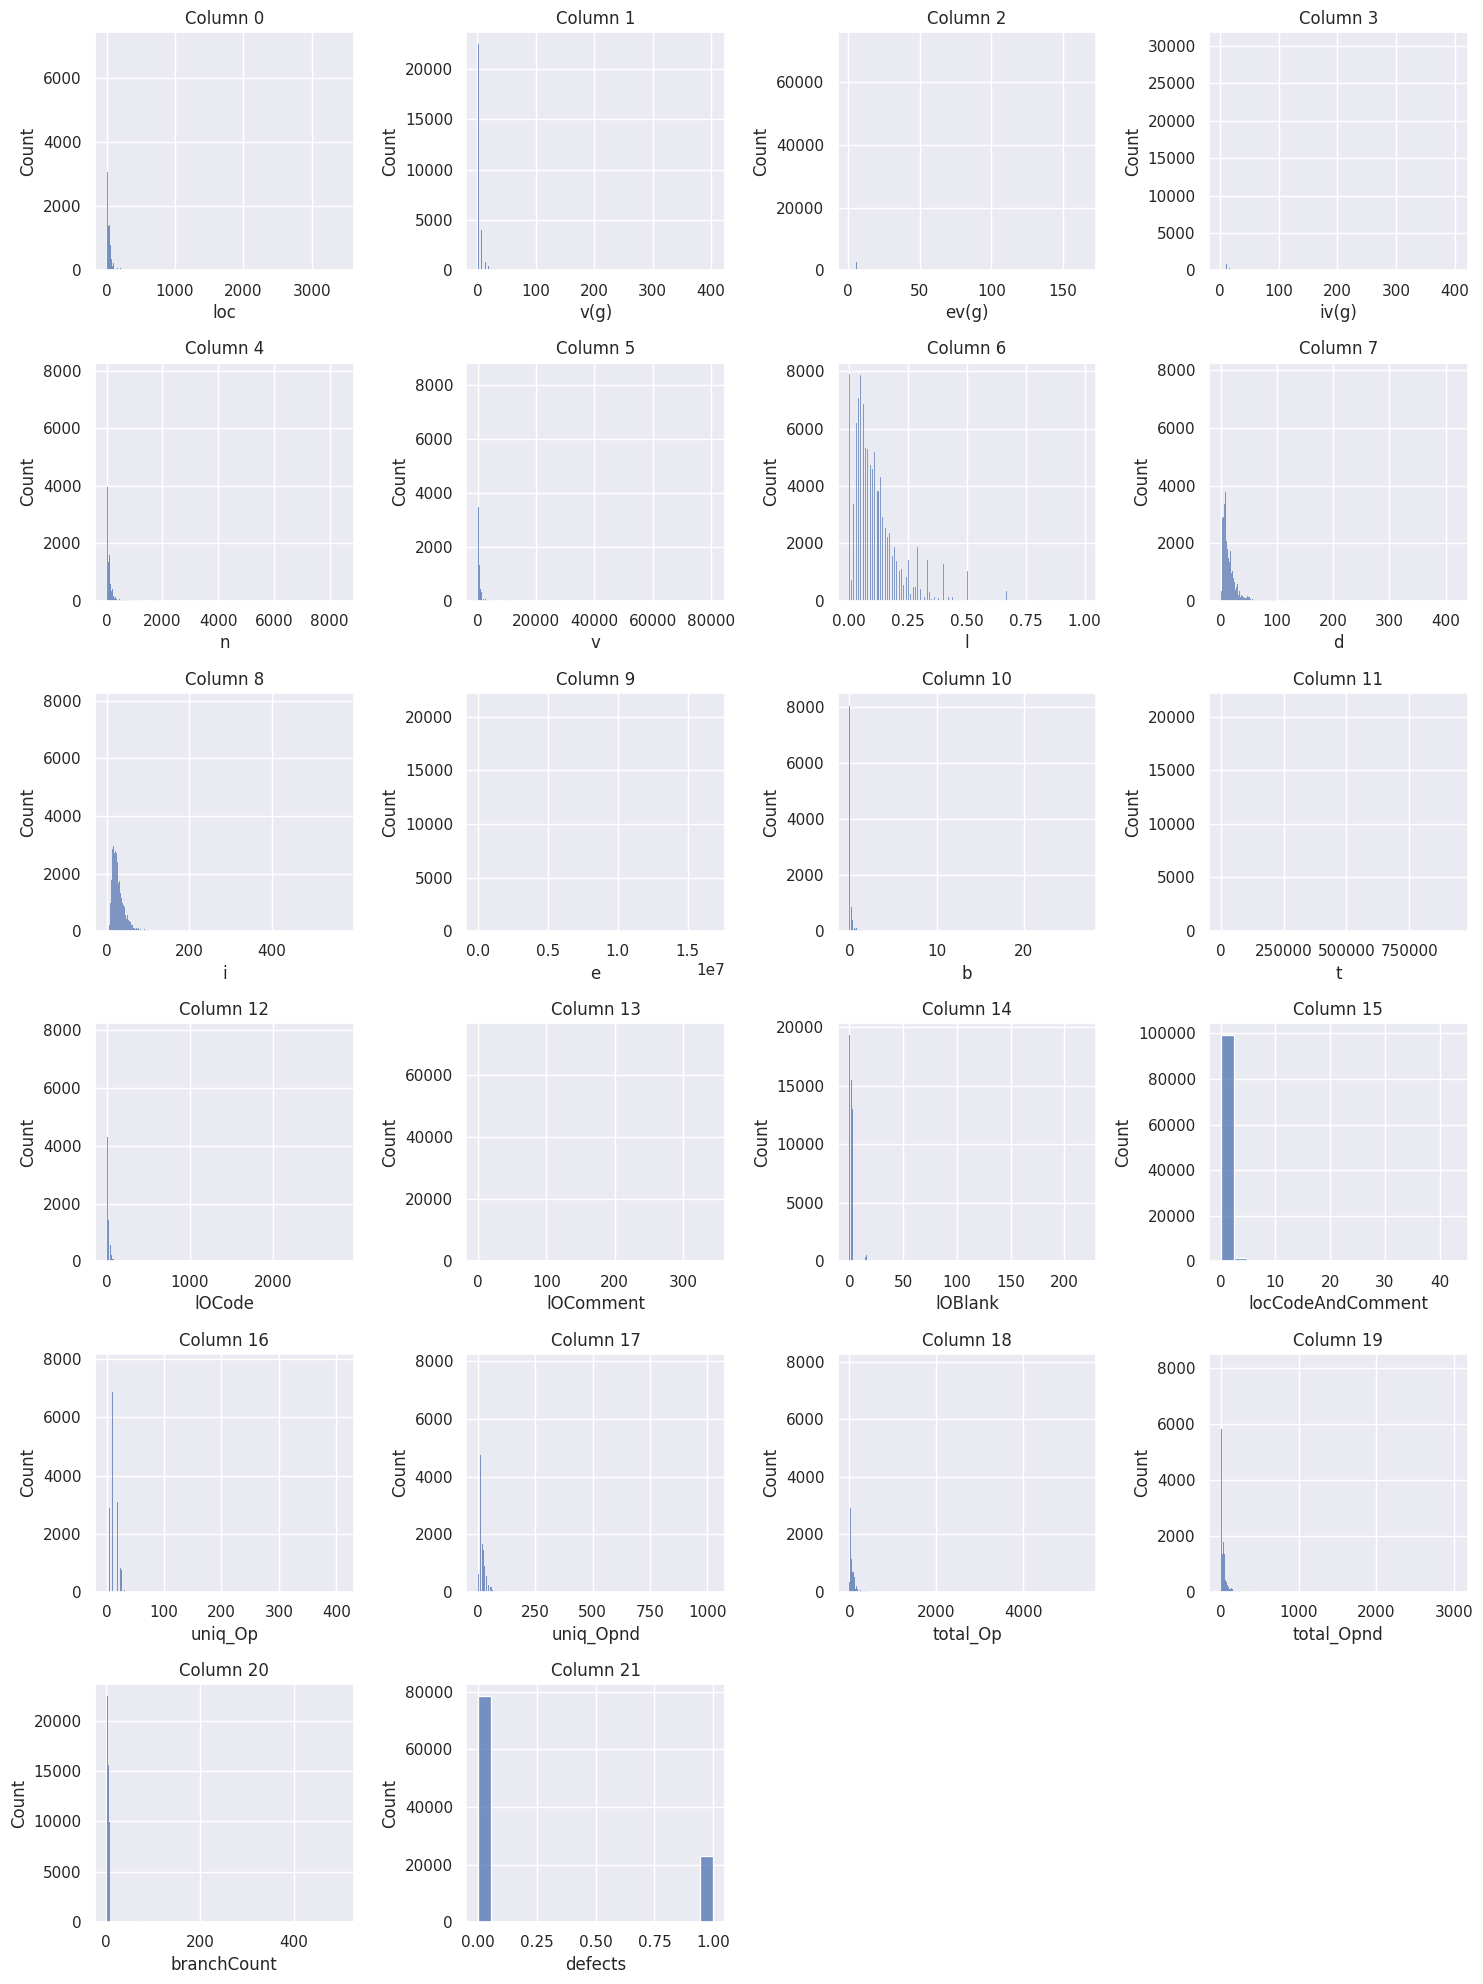

In [60]:
num_cols = len(df_train.columns)
rows = 6
cols = 4

fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(15, 20))

for i in range(rows):
    for j in range(cols):
        column_index = i * cols + j
        if column_index < num_cols:
            sns.histplot(df_train.iloc[:, column_index], ax=ax[i, j])
            ax[i, j].set_title(f'Column {column_index}')
        else:
            ax[i, j].axis('off')

plt.tight_layout()
plt.show()

#### Preparation Data

In [62]:
df_X = pd.concat([df_train, orig_train])
df_X = df_X.sample(frac=1, random_state=0)
df_y = df_X["defects"]
df_X = df_X.drop("defects", axis=1)

In [46]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = np.unique(df_y)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=df_y)

class_weights_dict = dict(zip(class_labels, class_weights))
print("class_weights:", class_weights_dict)

class_weights: {False: 0.6465329927953342, True: 2.2061004162330904}


In [56]:
X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.2, random_state=0, shuffle=True)

#### Gaussian Clustering

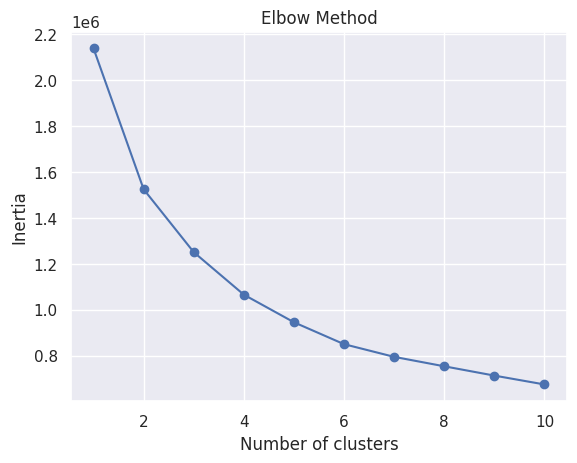

In [11]:
from sklearn.cluster import KMeans

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=15)
    kmeans.fit(df_X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [13]:
from sklearn.mixture import GaussianMixture
num_clusters = 10
gmm = GaussianMixture(n_components=num_clusters)
gmm.fit(df_X)
cluster_labels = gmm.predict(df_X)
df_X = pd.DataFrame(np.column_stack((df_X, cluster_labels)))

In [74]:
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

df_X = df_X.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)

models = {
    "xgb_clf" : xgb.XGBClassifier(n_estimators=round(263.8), colsample_bytree=0.3478,
                           max_depth=round(6.635), learning_rate=0.1328, max_bin=round(546.2),
                           min_child_samples=4.212, max_leaves=round(52.5), reg_alpha=5.27,
                           reg_lambda=0.8239, subsample=0.2812, class_weights=class_weights, verbosity=0),
    "cgb" : catboost.CatBoostClassifier(depth=round(4.149354071704496), iterations=round(1484.4327223226062),
                                        l2_leaf_reg=5.08927667625561, learning_rate=0.04209095522902819, min_data_in_leaf=10.590144889223629,
                                        class_weights=class_weights, verbose=False)
}

k_fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
        
y_hats = pd.DataFrame(index=X_train.index)
y_hats_auc_roc = pd.DataFrame(index=X_train.index)

for fold_num, (train_index, val_index) in tqdm(enumerate(k_fold.split(df_X, df_y))):
    for model_name, model in models.items():
        column_name = f"fold_{fold_num}_{model_name}"
        
        X_train_fold, X_val_fold = df_X.iloc[train_index], df_X.iloc[val_index]
        y_train_fold, y_val_fold = df_y.iloc[train_index], df_y.iloc[val_index]

        imputer = SimpleImputer()
        X_train_fold_imputed = imputer.fit_transform(X_train_fold)
        X_val_fold_imputed = imputer.transform(X_val_fold)

        model.fit(X_train_fold_imputed, y_train_fold)
        print(f"Fold: {fold_num+1}, Model: {model_name}")

0it [00:00, ?it/s]

Fold: 1, Model: xgb_clf
Fold: 1, Model: cgb
Fold: 2, Model: xgb_clf
Fold: 2, Model: cgb
Fold: 3, Model: xgb_clf
Fold: 3, Model: cgb
Fold: 4, Model: xgb_clf
Fold: 4, Model: cgb


#### LightGBM with bayes_opt

#### CatBoost with bayes_opt

In [ ]:
def cat_eval(iterations, depth, learning_rate, l2_leaf_reg, min_data_in_leaf):
    params = {
        'iterations': int(iterations),
        'depth': int(depth),
        'learning_rate': learning_rate,
        'l2_leaf_reg': l2_leaf_reg,
        'min_data_in_leaf': int(min_data_in_leaf),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'class_weights': class_weights,
        'verbose': False
    }
    cv_dataset = catboost.Pool(data=df_X, label=df_y)
    scores = catboost.cv(cv_dataset, params, fold_count=4, verbose=False)
    return scores['test-AUC-mean'].max()

pbounds = {
    'iterations': (100, 2000),
    'depth': (4, 10),
    'learning_rate': (0.001, 0.1),
    'l2_leaf_reg': (1, 10),
    'min_data_in_leaf': (1, 40)
}

cat_opt = BayesianOptimization(
    f=cat_eval,
    pbounds=pbounds
)

cat_opt.maximize(n_iter=6, init_points=4)

In [67]:
best_params = cat_opt.max
print(f"Best ROC-AUC: {best_params['target']}")
print(f"Best hyperparameters: {best_params['params']}")

Best ROC-AUC: 0.7869649844128364
Best hyperparameters: {'depth': 4.149354071704496, 'iterations': 1484.4327223226062, 'l2_leaf_reg': 5.08927667625561, 'learning_rate': 0.04209095522902819, 'min_data_in_leaf': 10.590144889223629}


In [23]:
cgb = catboost.CatBoostClassifier(
    depth=round(best_params['params']['depth']),
    iterations=round(best_params['params']['iterations']),
    l2_leaf_reg=best_params['params']['l2_leaf_reg'],
    learning_rate=best_params['params']['learning_rate'],
    min_data_in_leaf=best_params['params']['min_data_in_leaf'],
    class_weights=class_weights,
    verbose=False
)

# cgb.fit(X_train, y_train)
cgb.fit(df_X, df_y)
y_probs = cgb.predict_proba(X_val)[:, 1]

#### xgboost with bayes_opt

In [ ]:
def xgb_eval(n_estimators, learning_rate, subsample, num_leaves, max_bin, reg_alpha, reg_lambda, colsample_bytree, min_child_samples, depth):
    params = {
        'objective': 'binary:logistic',
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'num_leaves': int(num_leaves),
        'max_bin': int(max_bin),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'colsample_bytree': colsample_bytree,
        'min_child_samples': int(min_child_samples),
        'max_depth': int(depth),
        'class_weights': class_weights,
        'nthread': -1,
        'verbosity': 0,
        'seed': 0
    }

    cv_results = cross_val_score(xgb.XGBClassifier(**params), df_X, df_y, cv=4, scoring='roc_auc')
    return cv_results.mean()

pbounds = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.3),
    'subsample': (0.1, 1),
    'num_leaves': (10, 100),
    'max_bin': (100, 1000),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'colsample_bytree': (0.1, 1),
    'min_child_samples': (1, 50),
    'depth': (4, 10)
}

xgb_opt = BayesianOptimization(
    f=xgb_eval,
    pbounds=pbounds
)

xgb_opt.maximize(n_iter=6, init_points=4)

In [27]:
best_params = xgb_opt.max
print(f"Best ROC-AUC: {best_params['target']}")
print(f"Best hyperparameters: {best_params['params']}")

Best ROC-AUC: 0.7915753224368264
Best hyperparameters: {'colsample_bytree': 0.9152331863819801, 'depth': 6.80797958079809, 'learning_rate': 0.07070917643453672, 'max_bin': 994.7544357631093, 'min_child_samples': 6.7404595347405545, 'n_estimators': 100.82717414373778, 'num_leaves': 38.003807156600615, 'reg_alpha': 5.285532237372262, 'reg_lambda': 2.199907237829042, 'subsample': 0.7478348000379413}


In [34]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=round(best_params["params"]["n_estimators"]),
    colsample_bytree=best_params["params"]["colsample_bytree"],
    max_depth=round(best_params["params"]["depth"]),
    learning_rate=best_params["params"]["learning_rate"],
    max_bin=round(best_params["params"]["max_bin"]),
    min_child_weight=best_params["params"]["min_child_samples"],
    max_leaves=round(best_params["params"]["num_leaves"]),
    reg_alpha=best_params["params"]["reg_alpha"],
    reg_lambda=best_params["params"]["reg_lambda"],
    subsample=best_params["params"]["subsample"],
    verbosity=0
    )

# cgb.fit(X_train, y_train)
xgb_clf.fit(df_X, df_y)
y_probs = xgb_clf.predict_proba(X_val)[:, 1]

ROC-AUC: 0.8136058142134417


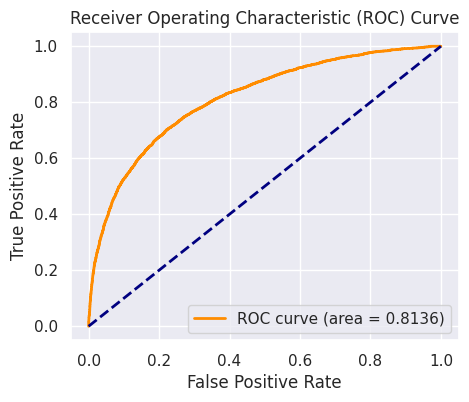

In [24]:
roc_auc = roc_auc_score(y_val, y_probs)
fpr, tpr, thresholds = roc_curve(y_val, y_probs)

print(f"ROC-AUC: {roc_auc}")
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Predict & sub data

In [26]:
def predict_sub(model, X, gmm=None, scaler=None):
    if scaler is not None:
        X = pd.DataFrame(scaler.transform(X))
    if gmm is not None:
        cluster_labels = gmm.predict(X)
        X = pd.DataFrame(np.column_stack((X, cluster_labels)))
    y_probs = model.predict_proba(X)[:, 1]
    return y_probs

In [28]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s3e23/sample_submission.csv")
df_sub["defects"] = predict_sub(cgb, df_test, gmm, scaler)
df_sub.to_csv("ans_11.csv", index=False)

#### CatBoost with bayes_opt - Public Score: 0.79009


